In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

In [2]:
map_oceans = plt.imread("../../maps/LOTR_MAPS_oceans.png")
map_rivers = plt.imread("../../maps/LOTR_MAPS_rivers.png")
map_hills = plt.imread("../../maps/LOTR_MAPS_hills.png")
map_mountains = plt.imread("../../maps/LOTR_MAPS_mountains.png")
map_ridges = plt.imread("../../maps/LOTR_MAPS_ridges.png")

wmap_oceans = popdyn.reader.extract_weightmap(map_oceans)
wmap_rivers = popdyn.reader.extract_weightmap(map_rivers)
wmap_hills = popdyn.reader.extract_weightmap(map_hills)
wmap_mountains = popdyn.reader.extract_weightmap(map_mountains)
wmap_ridges = popdyn.reader.extract_weightmap(map_ridges)

wmap_land = popdyn.reader.invert_weightmap(wmap_oceans)

In [3]:
raw_elevation = np.load("newheightmap.npy")

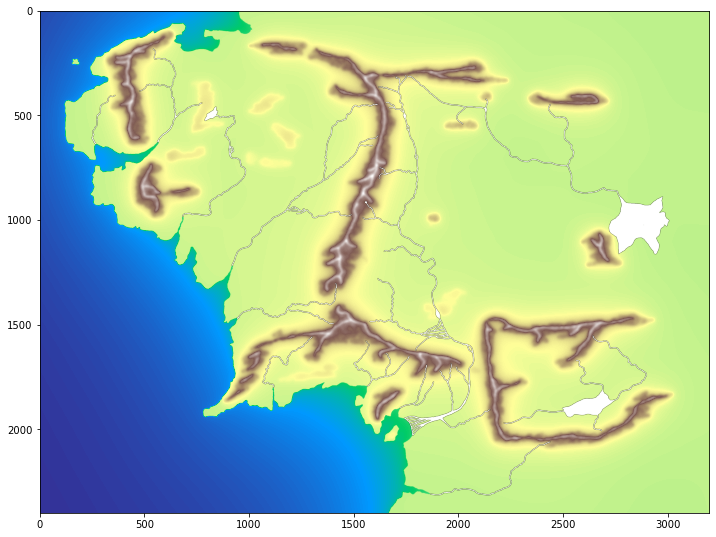

In [4]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(raw_elevation, cmap=plt.cm.terrain, )
ax.imshow(wmap_rivers, alpha=wmap_rivers, cmap=plt.cm.gray)


In [5]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

In [260]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
            print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [393]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.layers = np.sort(("terrain",))
        self.key = "terrain"
#         self.needed_keys ["terrain",]
        if flow_factor >= 1:
            raise ValueError("flow_factor must be less than 1, current value is {:.3f}".format(flow_factor))
        self.flow_factor = flow_factor
        
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
#         diffs[diffs < 0] = 0
        diffs[diffs < diffs.max(axis=0)] = 0. 
#         fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow = diffs * self.flow_factor # this is the outgoing amount
#         print(outflow)
        height_local = self.calc_flows(height_local, outflow, cell)
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

    def calc_flows(self, vmap, outflow, cell):
        vmap -= outflow.sum(axis=0)
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        vmap += shifted_landslide.sum(axis=0)        
        return vmap
         
class RainFall(FlowRule):
    def __init__(self, net_rainfall=0.5, rainmap=None):
        """
        This is adds new rain water to the water canvas
        
        Perhaps later this will be a non uniform rainfall pattern, once heat and cold is introduced to 
        account for evaporation
        
        rainmap is the characteristic rainfall pattern
        net rainfall is the amplitude of the rainmap
        """
        self.layers = np.sort(("water",))
        self.key = "water"
               
        self.net_rainfall = net_rainfall
        self.rainmap = rainmap
        
    def evolve(self,  cell):
        water_local = cell.canvases[self.key]
        
        if self.rainmap is not None:
            rainfall = self.rainmap * self.net_rainfall
        else:
            rainfall = np.ones(shape=water_local.shape) * self.net_rainfall
        water_local += rainfall
#         print(water_local)
        resdict = cell.canvases
        resdict.update({self.key: water_local})
        return resdict               
        

        
        
class Landslide(FlowRule):
    
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow = diffs * fractions * self.flow_factor # this is the outgoing amount
        
        height_local = self.calc_flows(cell, height_local, outflow)
        
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict
        
    
class WaterFlow(FlowRule):
    def __init__(self, wmap_ocean, water_flow_rate=0.5, land_coerosion_rate=0.1):
        """
        This is a two component erosion model where water flows fast, and drags a fraction of the land with it
        
        wflow_rate is the water flaw per time step
        lflow rate is the land coerosion per time step, this should be much smaller than the water flow rate
        
        The local gradient step is determined by the total land plus water height,
        and each component is dragged separately
        
        """
        self.layers = np.sort(("water", "terrain"))
        self.wkey = "water"
        self.lkey = "terrain"
        self.water_flow_rate = water_flow_rate
        self.land_coerosion_rate = land_coerosion_rate
        

        self.wmap_ocean = wmap_ocean
        self.ii = wmap_ocean.astype(bool).flatten()

                
    def evolve(self, cell):
        np.set_printoptions(suppress=True)
        col = 15
        # these are the only canvases we are going to care about at all
        height_local = cell.canvases[self.lkey]
        height_shifted = cell.shifted_canvases[self.lkey]
        water_local = cell.canvases[self.wkey]
        water_shifted = cell.shifted_canvases[self.wkey]

        diffs = (height_local + water_local) - (height_shifted + water_shifted)
        ii =  diffs < diffs.max(axis=0)
        diffs[ii] = 0. 
#         print(diffs.max())
#         print(diffs.max(), diffs.min())
#         wdiffs = diffs *(water_local - water_shifted)
#         wdiffs[ii] = 0
        outflow_w =  diffs * water_local * self.water_flow_rate
        
#         print(height_local.max(), water_local.max())
#         print(height_local.min(), water_local.min())
        ldiffs = (height_local - height_shifted)
        ldiffs[ii] = 0
        outflow_l = self.land_coerosion_rate * ldiffs
#         print(outflow_w.max(), outflow_l.max())
        water_local = self.calc_flows(water_local, outflow_w, cell)
        height_local = self.calc_flows(height_local, outflow_l, cell)

#         water_local.flat[self.ii] = -1 * height_local.flat[self.ii]

        resdict = cell.canvases
        resdict.update({self.wkey: water_local, self.lkey: height_local})
        
        np.set_printoptions(suppress=False)
        return resdict    
    
        


In [394]:
tmap = raw_elevation[:1000, :1000].copy()

wmap = np.ones(tmap.shape) + 100.

# wmap.
scale = 0.1
tmap = sktransform.rescale(tmap, scale=scale)
wmap = sktransform.rescale(wmap, scale=scale)
# ocean_map = np.round(sktransform.rescale(wmap_oceans[:1000, :1000], scale=scale))
# ii = ocean_map.astype(bool).flatten()
# wmap.flat[ii] = -1 * tmap.flat[ii] # oceans are filled with water to the brink

initial_maps = {
    "terrain": tmap,# + 5000,
    "water": wmap,
}
rules = (
#     RainFall(net_rainfall=0.32),
    WaterFlow(ocean_map, land_coerosion_rate=0.4, water_flow_rate=0.4),
#     Cleanup(ocean_map),
)


In [395]:
cs = CellSpace(initial_maps, rules)
cs.flow(1000, savestep=10)

waters = np.array(cs.maps["water"])
terrain = np.array(cs.maps["terrain"])

0 out of 999
1 out of 999
2 out of 999
3 out of 999
4 out of 999
5 out of 999
6 out of 999
7 out of 999
8 out of 999
9 out of 999
10 out of 999
11 out of 999
12 out of 999
13 out of 999
14 out of 999
15 out of 999
16 out of 999
17 out of 999
18 out of 999
19 out of 999
20 out of 999
21 out of 999
22 out of 999
23 out of 999
24 out of 999
25 out of 999
26 out of 999
27 out of 999
28 out of 999
29 out of 999
30 out of 999
31 out of 999
32 out of 999
33 out of 999
34 out of 999
35 out of 999
36 out of 999
37 out of 999
38 out of 999
39 out of 999
40 out of 999
41 out of 999
42 out of 999
43 out of 999
44 out of 999
45 out of 999
46 out of 999
47 out of 999
48 out of 999
49 out of 999
50 out of 999
51 out of 999
52 out of 999
53 out of 999
54 out of 999
55 out of 999
56 out of 999
57 out of 999
58 out of 999
59 out of 999
60 out of 999
61 out of 999
62 out of 999
63 out of 999
64 out of 999
65 out of 999
66 out of 999
67 out of 999
68 out of 999
69 out of 999
70 out of 999
71 out of 999
72

643 out of 999
644 out of 999
645 out of 999
646 out of 999
647 out of 999
648 out of 999
649 out of 999
650 out of 999
651 out of 999
652 out of 999
653 out of 999
654 out of 999
655 out of 999
656 out of 999
657 out of 999
658 out of 999
659 out of 999
660 out of 999
661 out of 999
662 out of 999
663 out of 999
664 out of 999
665 out of 999
666 out of 999
667 out of 999
668 out of 999
669 out of 999
670 out of 999
671 out of 999
672 out of 999
673 out of 999
674 out of 999
675 out of 999
676 out of 999
677 out of 999
678 out of 999
679 out of 999
680 out of 999
681 out of 999
682 out of 999
683 out of 999
684 out of 999
685 out of 999
686 out of 999
687 out of 999
688 out of 999
689 out of 999
690 out of 999
691 out of 999
692 out of 999
693 out of 999
694 out of 999
695 out of 999
696 out of 999
697 out of 999
698 out of 999
699 out of 999
700 out of 999
701 out of 999
702 out of 999
703 out of 999
704 out of 999
705 out of 999
706 out of 999
707 out of 999
708 out of 999
709 out of

In [396]:
waters

array([[[101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        ...,
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.]],

       [[101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        ...,
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.]],

       [[101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        ...,
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.],
        [101., 101., 101., ..., 101., 101., 101.]],

       ...,

       [[101., 101., 101

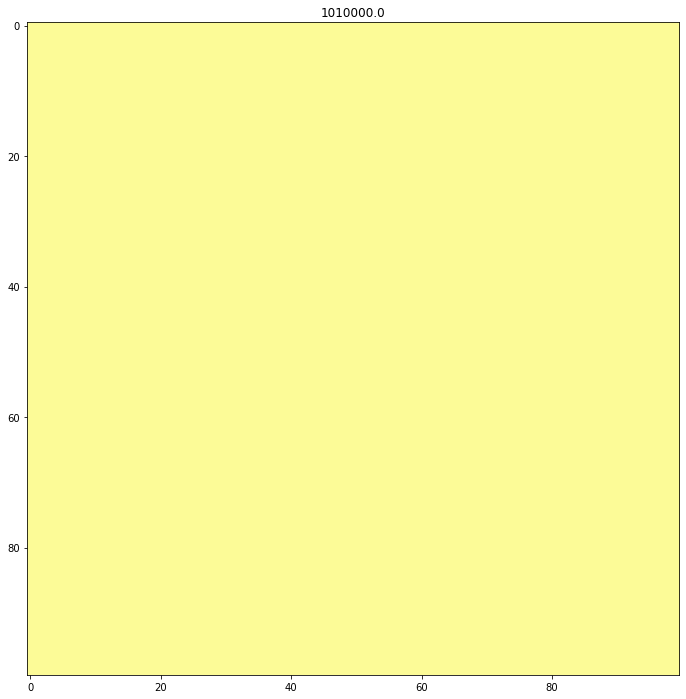

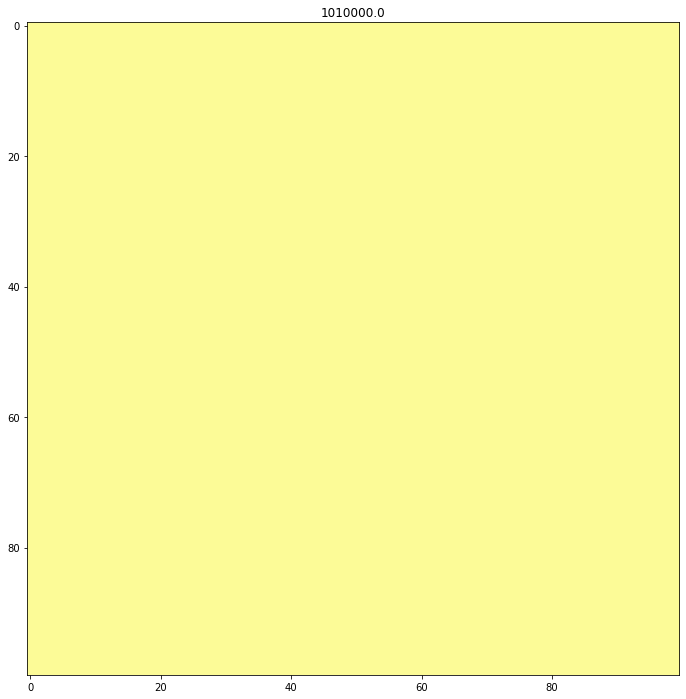

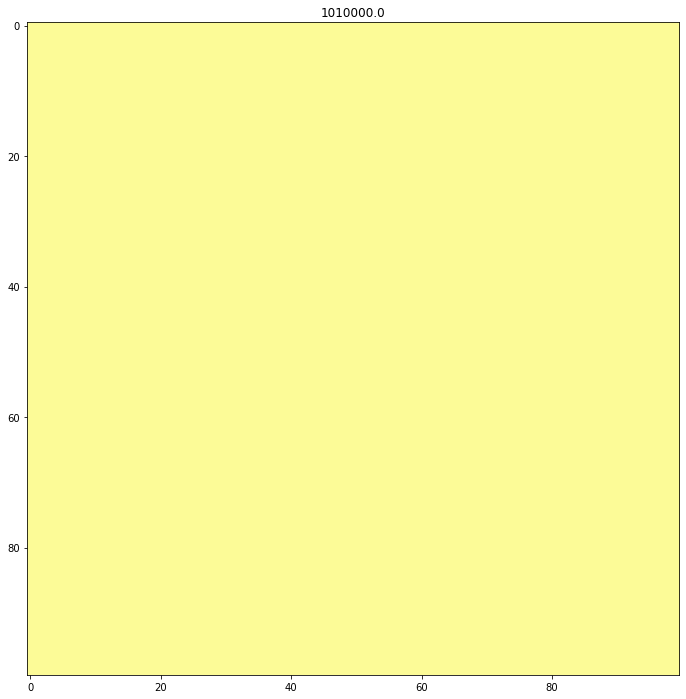

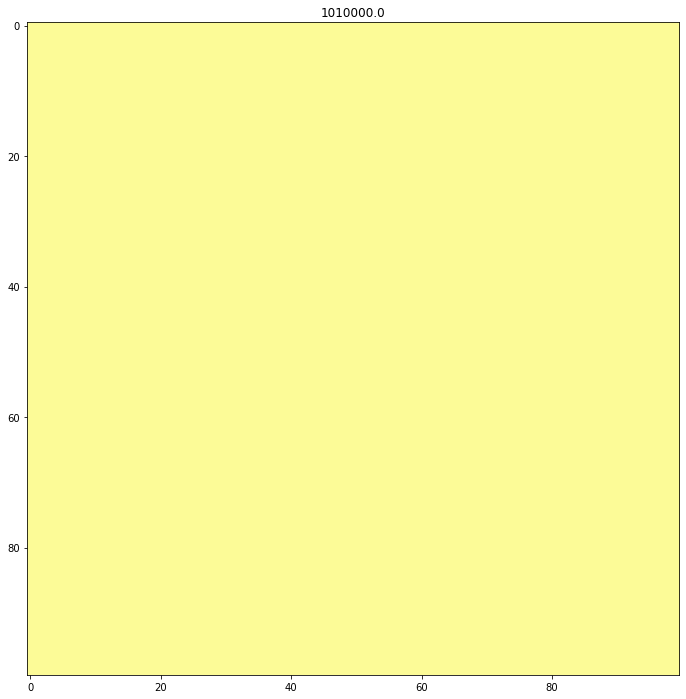

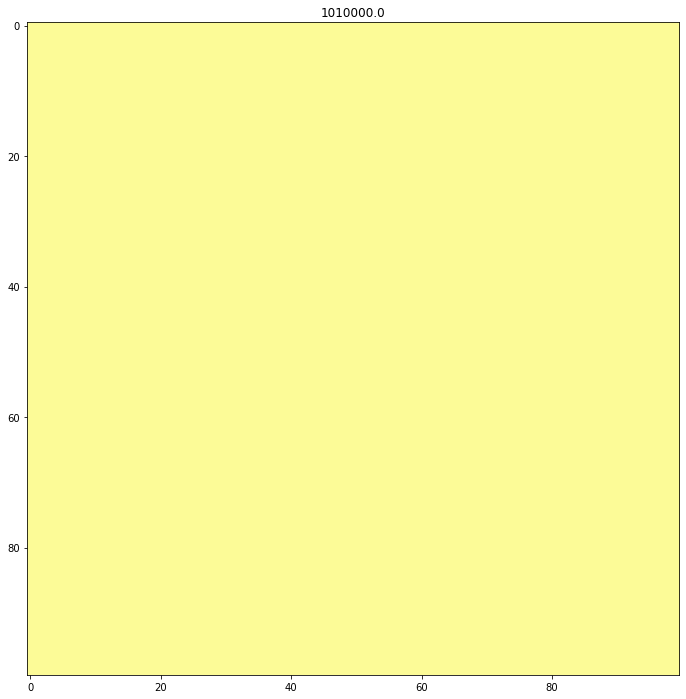

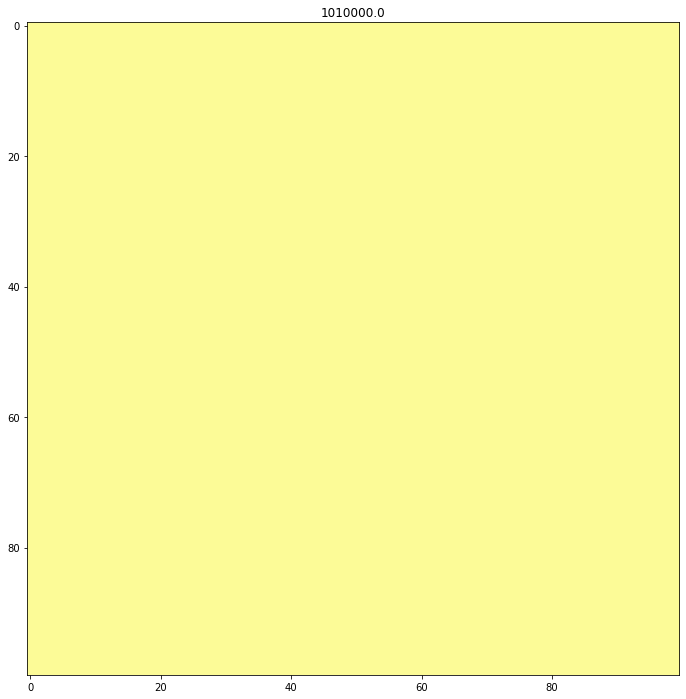

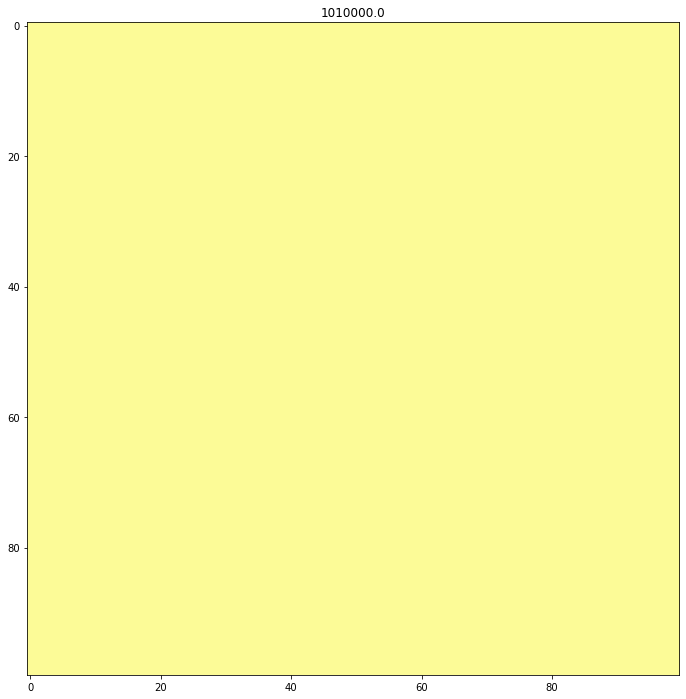

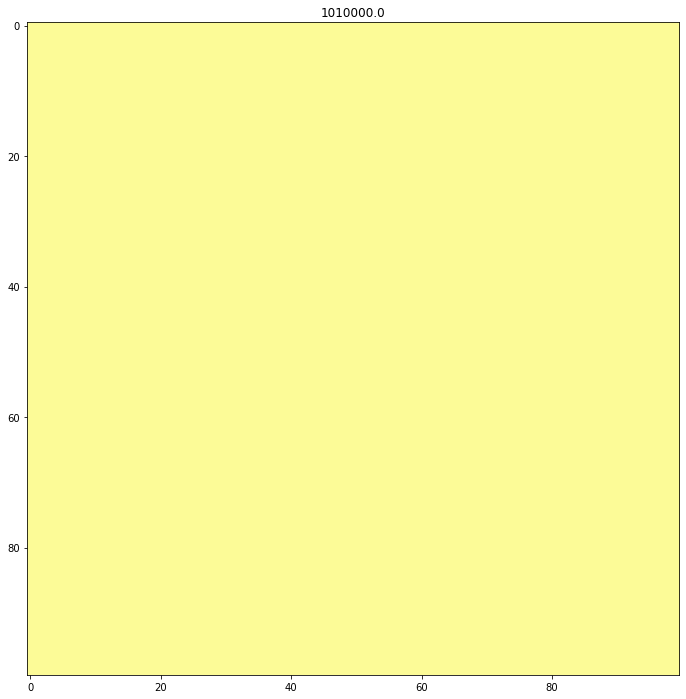

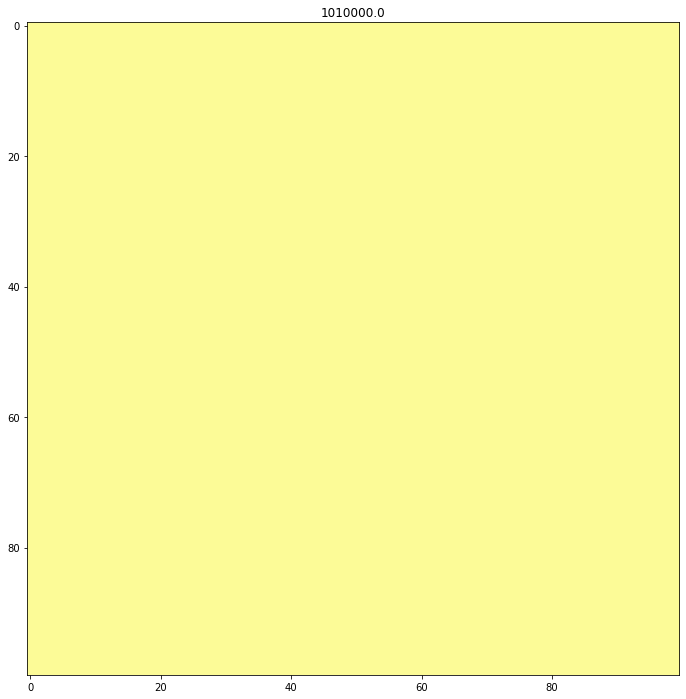

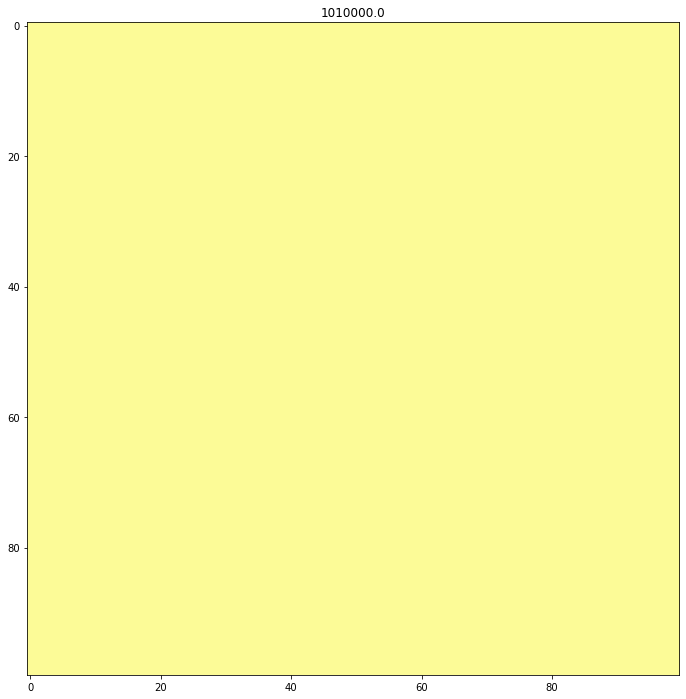

In [391]:
for i in np.arange(0, 10):

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)

    ww = waters[i + 1]
#     hh = terrain[i+1] - terrain[i]
    hh = terrain[i]# - 5000
#     ax.imshow(hh)
    ax.imshow(ww, cmap=plt.cm.terrain, norm=mpl.colors.Normalize(vmin=0, vmax=200))
    ax.set_title(ww.sum())
#     ax.imshow(ww, norm=mpl.colors.Normalize(vmin=0, vmax=2000))
    

In [392]:
ww

array([[101., 101., 101., ..., 101., 101., 101.],
       [101., 101., 101., ..., 101., 101., 101.],
       [101., 101., 101., ..., 101., 101., 101.],
       ...,
       [101., 101., 101., ..., 101., 101., 101.],
       [101., 101., 101., ..., 101., 101., 101.],
       [101., 101., 101., ..., 101., 101., 101.]])

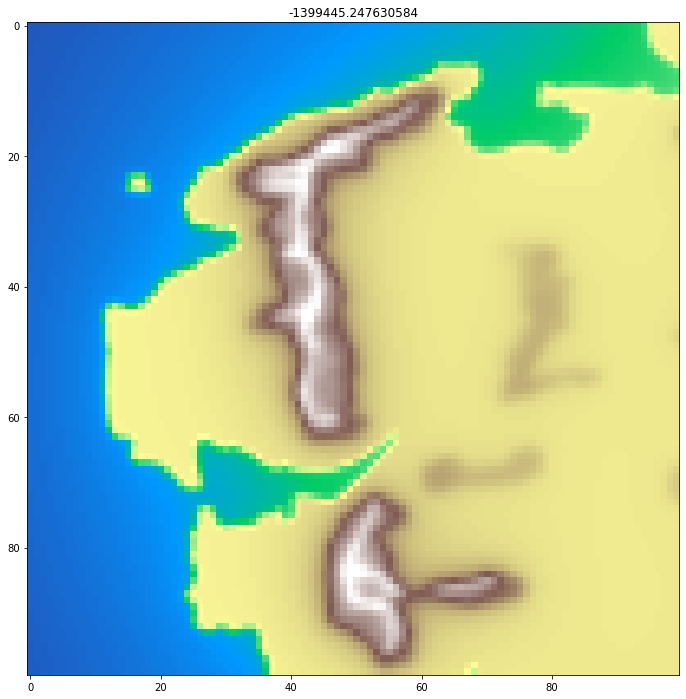

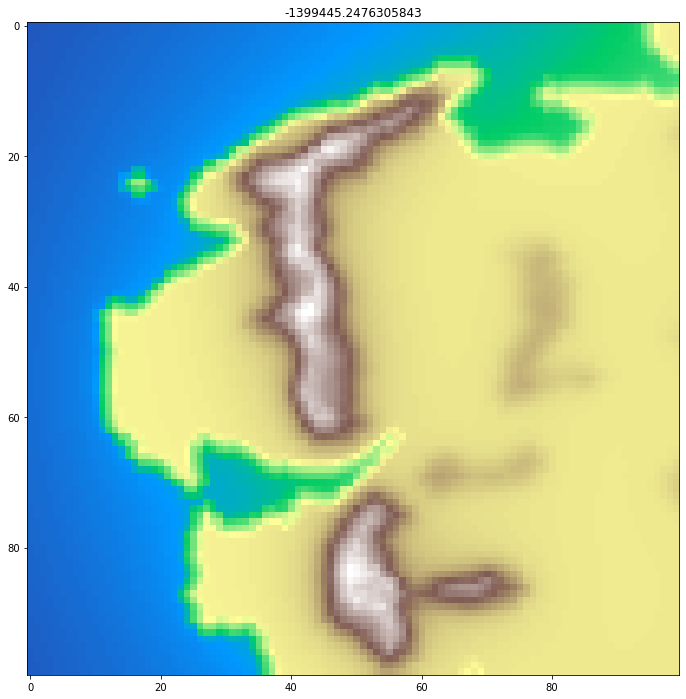

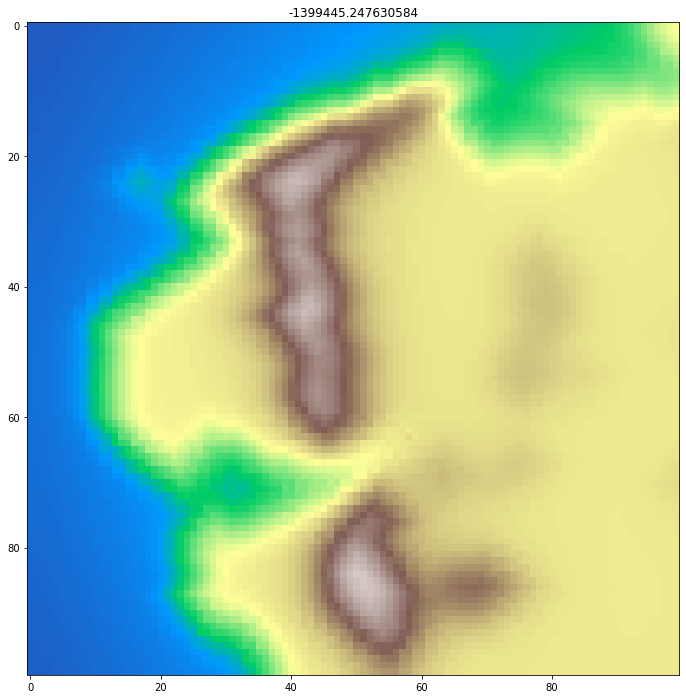

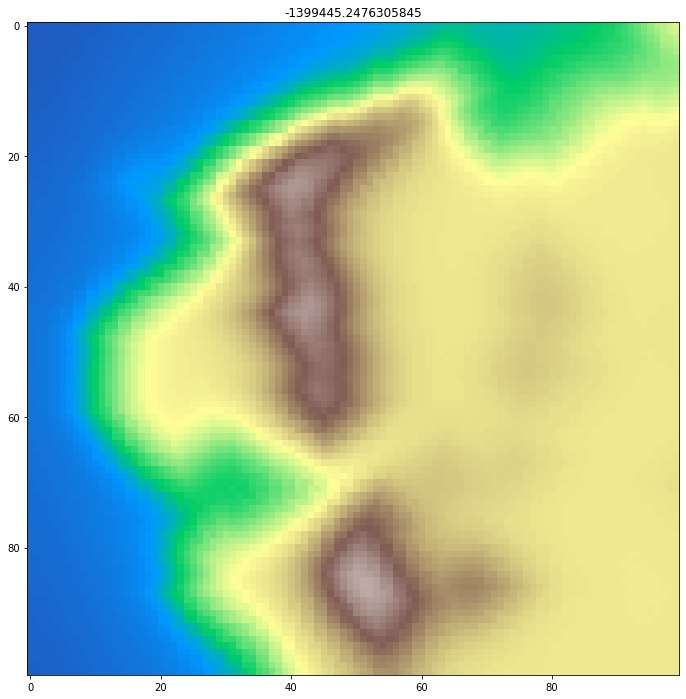

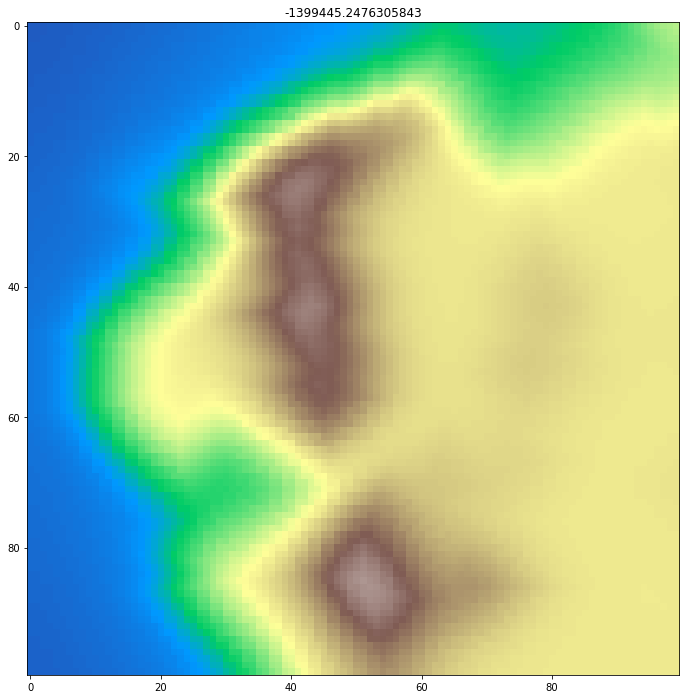

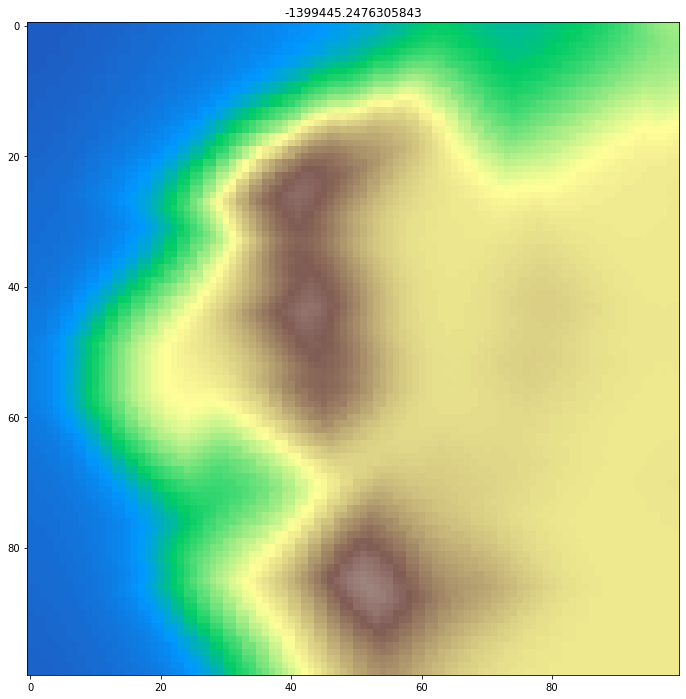

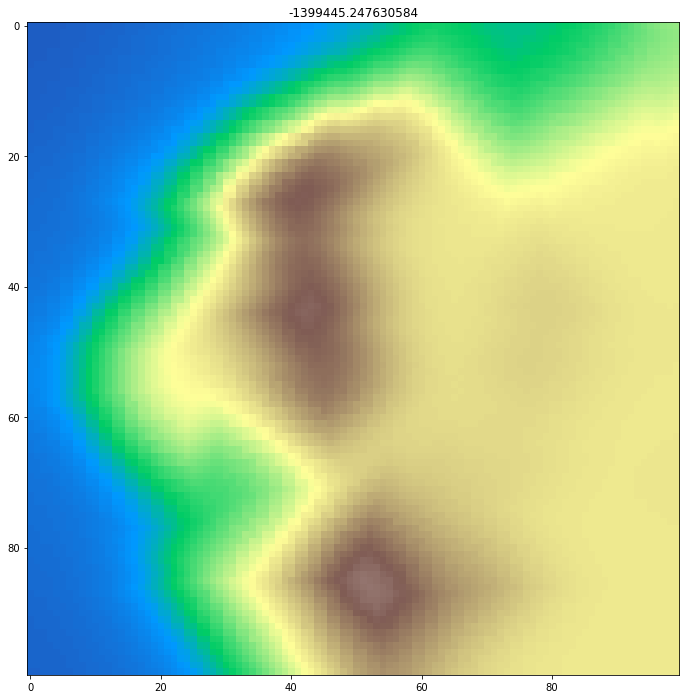

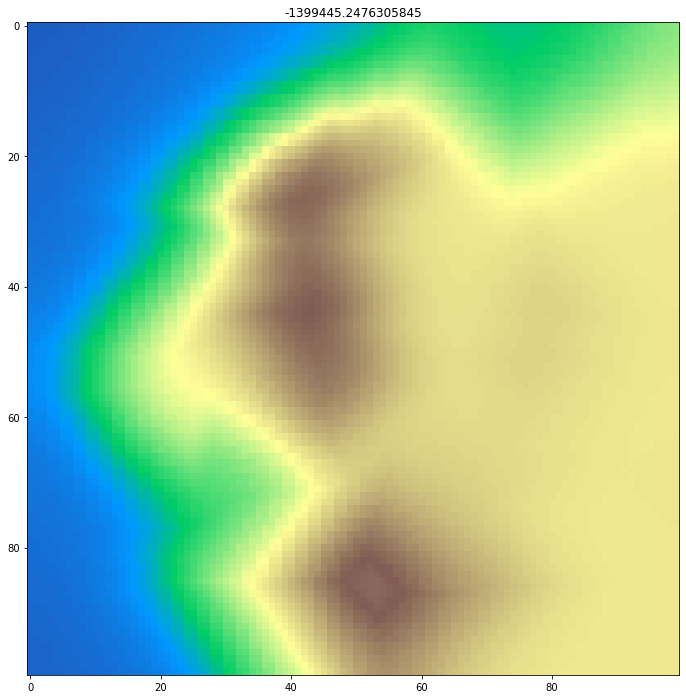

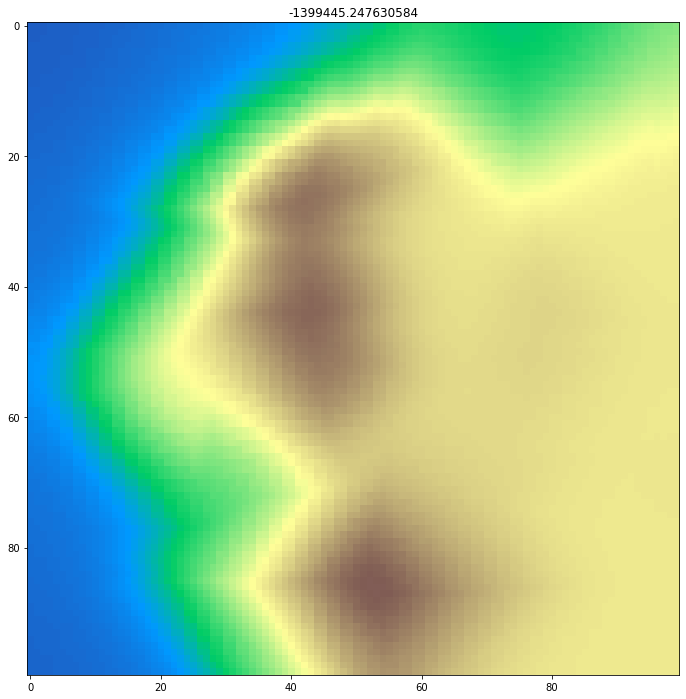

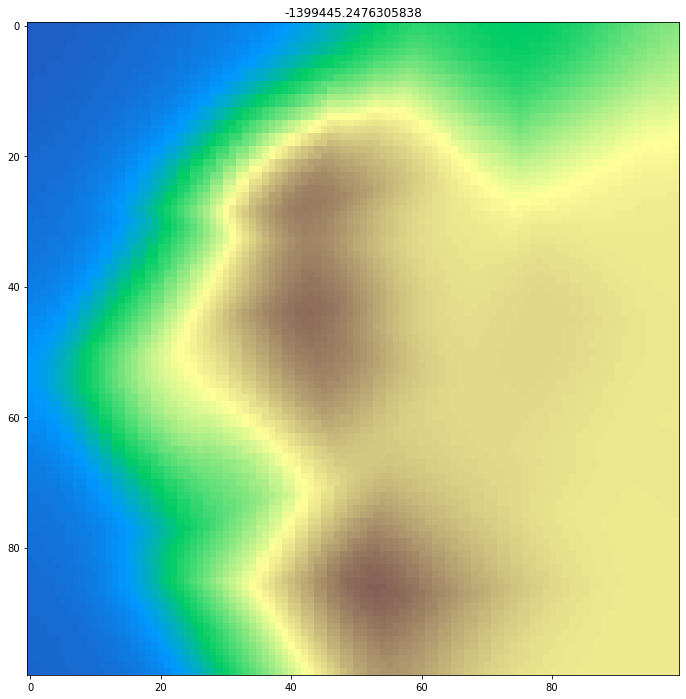

In [380]:
for i in np.arange(0, 10):

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)

    ww = waters[i + 1]
#     hh = terrain[i+1] - terrain[i]
    hh = terrain[i]# - 5000
#     ax.imshow(hh)
    ax.imshow(hh, cmap=plt.cm.terrain, norm=mpl.colors.Normalize(vmin=-1000, vmax=1000))
    ax.set_title(hh.sum())
#     ax.imshow(ww, norm=mpl.colors.Normalize(vmin=0, vmax=2000))
    


In [356]:
hh.min()

4110.063270046011

In [341]:
hh.max()

3513.958308781116

In [199]:
plt.plot(hh[130, :])

IndexError: index 130 is out of bounds for axis 0 with size 5

In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, 10))
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.set_xlim(0,200)
ax.axhline(0, ls="--", color="red")
ax.plot(terrain[0][41, :], color="black")
for i, w in enumerate(terrain[:10]):
# #     print(w.sum())
#     ax.plot(np.sqrt(w[41, :]))
    ax.plot(w[41, :], color=colors[i])
# ax.set_ylim(0, 1000)

In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, 10))
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.set_xlim(0,200)
ax.axhline(0, ls="--", color="red")
ax.plot(terrain[0][41, :], color="black")
for i, w in enumerate(terrain[:10]):
# #     print(w.sum())
#     ax.plot(np.sqrt(w[41, :]))
    ax.plot(w[41, :], color=colors[i])
ax.set_ylim(0, 1000)

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.set_xlim(0,200)
ax.axhline(0, ls="--", color="red")
ax.plot(terrain[0][41, :], color="black")
for w in waters[:10]:
# #     print(w.sum())
    ax.plot(np.sqrt(w[41, :]))
    ax.plot(w[41, :])

In [ ]:
for i in np.arange(10):

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)

    ww = waters[i]
    hh = terrain[i]
    
    ax.imshow(hh, cmap=plt.cm.terrain, norm=mpl.colors.Normalize(vmin=-300))


In [ ]:
plt.plot(waters[1][:, 0])
plt.plot(terrain[1][:, 0])

In [ ]:
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)

In [ ]:
plt.imshow(waters[10])

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.set_xlim(0, 200)
ax.axhline(0, ls="--", color="red")
ax.plot(terrain[0][41, :], color="black")
for w in waters[:10]:
# #     print(w.sum())
    ax.plot(w[41, :])

In [ ]:
plt.imshow(terrain[0])

In [ ]:
for i in np.arange(20):
# for i in np.ara
#     print(waters[i].max())
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
#     ax.imshow(terrain[i], cmap=plt.cm.terrain, )
    ax.imshow(waters[i])
#     ax = fig.add_subplot(111)
#     ax.imshow(terrain[i])

In [22]:
raw_elevation.flat[wmap_oceans.astype(bool).flatten()]

array([-890.80856635, -890.56143394, -890.31396528, ..., -508.08080638,
       -501.60531363, -494.75961226])

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

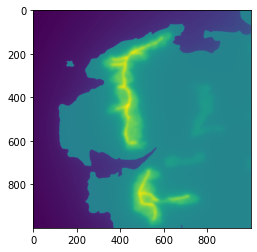

In [15]:
plt.imshow(tmap)